In [1]:
import pandas as pd
import os
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from dataset_clean import prep_stock_data, prep_news_data, dataframe_union
from dataset_fetch import fetch_datasets, fetch_stock_datasets
from sent_models import sentiment_analysis
from helper_funcs import mda

STOCK_PATH = 'stock_data'
NEWS_PATH = 'news_data'

#===============================#===================================#
#                   Main Data Processing Pipeline
#===============================#===================================#

print("\nFetching datasets...")
fetch_datasets('datasets/news_data.zip', 'datasets/stock_data.zip', NEWS_PATH, STOCK_PATH)

news_dataframe = pd.read_json(f"{os.getcwd()}/news_data/News_Category_Dataset_v3.json", lines=True)
stock_meta_file = pd.read_csv(f"{os.getcwd()}/stock_data/symbols_valid_meta.csv")

print("\nPreparing stock datasets...")
stock_dataframes = fetch_stock_datasets(stock_meta_file, STOCK_PATH)

print("\nCleaning stock datasets...")
cleaned_news_data = prep_news_data(news_dataframe, stock_dataframes)
cleaned_stock_data = prep_stock_data(stock_dataframes)

print("\nGenerating sentiment analysis on news data...")
sentiment_news_data = sentiment_analysis(cleaned_news_data)

print("\nCombining stocks with daily sentiment, this may take a while...")
final_dataframe = dataframe_union(cleaned_stock_data, sentiment_news_data)

print("\nFinal dataset ready for modeling.\n")


Fetching datasets...
News data already extracted in news_data. Skipping extraction.
Stock data already extracted in stock_data. Skipping extraction.

Preparing stock datasets...
Could not load data for ticker: AGM$A
Could not load data for ticker: CARR.V
Could not load data for ticker: UTX.V

Cleaning stock datasets...
Dropping VST: invalid 1 day return

Number of Stocks before processing: 	5881
Number of Stocks after processing: 	3284


Generating sentiment analysis on news data...

Combining stocks with daily sentiment, this may take a while...

Final dataset ready for modeling.



In [2]:
#===============================#===================================#
#                   XGBoost Modeling Pipeline
#===============================#===================================#
x_features = ['Open'] + list(cleaned_news_data['category'].unique())    # Generate feature list for XGBoost
X = final_dataframe[x_features] # Input features

y_0d = final_dataframe['r_0d']  # Target variable: 0 day return
y_1d = final_dataframe['r_1d']  # Target variable: 1 day return
y_7d = final_dataframe['r_7d']  # Target variable: 7 day return
y_30d = final_dataframe['r_30d']# Target variable: 30 day return

# XGBoost Hyperparameters
N_EST = 1000
LAMBDA = 0.05
MAX_DEPTH = 6
SUB_SAMP = 0.8
OBJECTIVE = 'reg:squarederror'
METHOD = 'hist'

# ====================== 0 Day Return Model ====================== #   
if os.path.exists("xgb_models/xgb_model_0d.json") and False:   # Disabled due to model not saving evaluation results properly
    print(f"\nLoading pre-trained 0 day return model...")
    model_0d = xgb.Booster()
    model_0d = model_0d.load_model("xgb_models/xgb_model_0d.json")
else:
    print(f"\nTraining new 0 day return model...")
    X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y_0d, test_size=0.2, random_state=42)

    model_0d = xgb.XGBRegressor(
        n_estimators=N_EST, reg_lambda=LAMBDA, max_depth=MAX_DEPTH,
        subsample=SUB_SAMP, objective=OBJECTIVE, tree_method=METHOD,
        eval_metric=['rmse', mda]
    )

    model_0d.fit(
        X_train0, y_train0,
        eval_set=[(X_test0, y_test0)],
        verbose=False
    )

# ====================== 1 Day Return Model ====================== #   
if os.path.exists("xgb_models/xgb_model_1d.json") and False:   # Disabled due to model not saving evaluation results properly
    print(f"\nLoading pre-trained 1 day return model...")
    model_1d = xgb.Booster()
    model_1d = model_1d.load_model("xgb_models/xgb_model_1d.json")
else:
    print(f"\nTraining new 1 day return model...")
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_1d, test_size=0.2, random_state=42)

    model_1d = xgb.XGBRegressor(
        n_estimators=N_EST, reg_lambda=LAMBDA, max_depth=MAX_DEPTH,
        subsample=SUB_SAMP, objective=OBJECTIVE, tree_method=METHOD,
        eval_metric=['rmse', mda]
    )
    
    model_1d.fit(
        X_train1, y_train1,
        eval_set=[(X_test1, y_test1)],
        verbose=False
    )

# ====================== 7 Day Return Model ====================== #   
if os.path.exists("xgb_models/xgb_model_7d.json") and False:   # Disabled due to model not saving evaluation results properly
    print(f"\nLoading pre-trained 7 day return model...")
    model_7d = xgb.Booster()
    model_7d = model_7d.load_model("xgb_models/xgb_model_7d.json")
else:
    print(f"\nTraining new 7 day return model...")
    X_train7, X_test7, y_train7, y_test7 = train_test_split(X, y_7d, test_size=0.2, random_state=42)

    model_7d = xgb.XGBRegressor(
        n_estimators=N_EST, reg_lambda=LAMBDA, max_depth=MAX_DEPTH,
        subsample=SUB_SAMP, objective=OBJECTIVE, tree_method=METHOD,
        eval_metric=['rmse', mda]
    )
    
    model_7d.fit(
        X_train7, y_train7,
        eval_set=[(X_test7, y_test7)],
        verbose=False
    )

# ====================== 30 Day Return Model ====================== #   
if os.path.exists("xgb_models/xgb_model_30d.json") and False:   # Disabled due to model not saving evaluation results properly
    print(f"\nLoading pre-trained 30 day return model...")
    model_30d = xgb.Booster()
    model_30d = model_30d.load_model("xgb_models/xgb_model_30d.json")
else:
    print(f"\nTraining new 30 day return model...")
    X_train30, X_test30, y_train30, y_test30 = train_test_split(X, y_30d, test_size=0.2, random_state=42)

    model_30d = xgb.XGBRegressor(
        n_estimators=N_EST, reg_lambda=LAMBDA, max_depth=MAX_DEPTH,
        subsample=SUB_SAMP, objective=OBJECTIVE, tree_method=METHOD,
        eval_metric=['rmse', mda]
    )
    
    model_30d.fit(
        X_train30, y_train30,
        eval_set=[(X_test30, y_test30)],
        verbose=False
    )
print(f"\nModel training/loading complete.\n")


Training new 0 day return model...

Training new 1 day return model...

Training new 7 day return model...

Training new 30 day return model...

Model training/loading complete.




Calculating RMSE for each model...
0 Day Return RMSE: 0.023546
1 Day Return RMSE: 0.087180
7 Day Return RMSE: 0.114658
30 Day Return RMSE: 0.210973



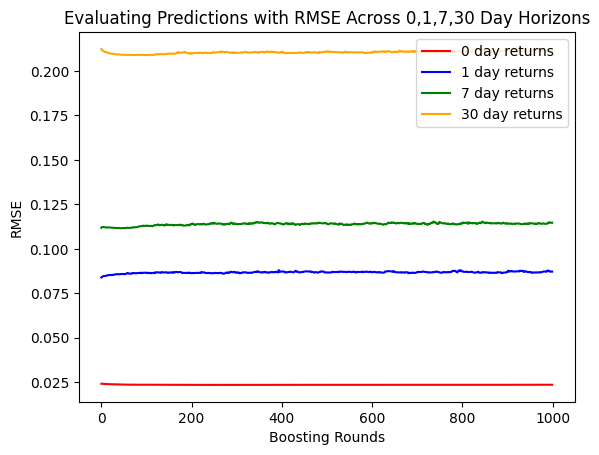


Calculating MDA for each model...
0 Day Return MDA: 0.583349
1 Day Return MDA: 0.603313
7 Day Return MDA: 0.629042
30 Day Return MDA: 0.627879



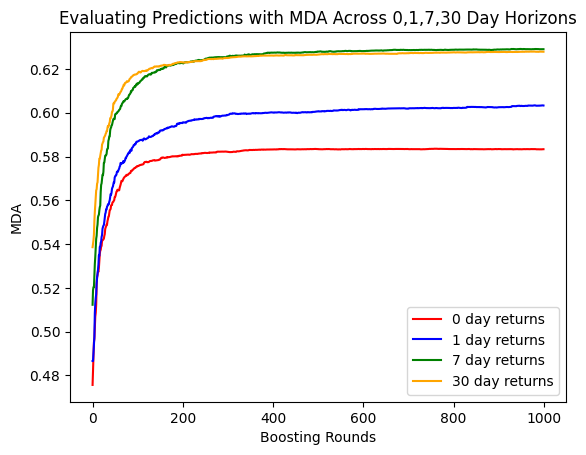


Generating feature importance scores...

Top 5 Feature Importances for 0 Day Return Model:
PARENTING: 0.1011
FOOD & DRINK: 0.0478
TECHNOLOGY: 0.0431
ARTS & CULTURE: 0.0414
WELLNESS: 0.0414

Top 5 Feature Importances for 1 Day Return Model:
BLACK VOICES: 0.0586
EDUCATION: 0.0577
TASTE: 0.0481
QUEER VOICES: 0.0415
STYLE: 0.0406

Top 5 Feature Importances for 7 Day Return Model:
HEALTHY LIVING: 0.0459
PARENTS: 0.0444
QUEER VOICES: 0.0431
STYLE: 0.0423
WORLD NEWS: 0.0411

Top 5 Feature Importances for 30 Day Return Model:
PARENTING: 0.0815
Open: 0.0511
TRAVEL: 0.0460
WEIRD NEWS: 0.0417
TASTE: 0.0385
End of Stock Prediction Pipeline.



In [3]:
#===============================#===================================#
#                       Model Evaluation
#===============================#===================================#
eval_0 = model_0d.evals_result()['validation_0']
eval_1 = model_1d.evals_result()['validation_0']    
eval_7 = model_7d.evals_result()['validation_0']
eval_30 = model_30d.evals_result()['validation_0']

# =====================  RMSE Evaluation ========================== #
os.makedirs('figures', exist_ok=True)

print("\nCalculating RMSE for each model...")
print(f"0 Day Return RMSE: {eval_0['rmse'][-1]:.6f}")
print(f"1 Day Return RMSE: {eval_1['rmse'][-1]:.6f}")
print(f"7 Day Return RMSE: {eval_7['rmse'][-1]:.6f}")
print(f"30 Day Return RMSE: {eval_30['rmse'][-1]:.6f}\n")

plt.plot(eval_0['rmse'], color='red', label='0 day returns')
plt.plot(eval_1['rmse'], color='blue', label='1 day returns')
plt.plot(eval_7['rmse'], color='green', label='7 day returns')
plt.plot(eval_30['rmse'], color='orange', label='30 day returns')

plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Evaluating Predictions with RMSE Across 0,1,7,30 Day Horizons')
plt.legend()

plt.savefig("figures/rmse_evaluation.png")
plt.show()

# ===================== MDA Evaluation ========================== #
print("\nCalculating MDA for each model...")
print(f"0 Day Return MDA: {eval_0['mda'][-1]:.6f}")
print(f"1 Day Return MDA: {eval_1['mda'][-1]:.6f}")
print(f"7 Day Return MDA: {eval_7['mda'][-1]:.6f}")
print(f"30 Day Return MDA: {eval_30['mda'][-1]:.6f}\n")

plt.plot(eval_0['mda'], color='red', label='0 day returns')
plt.plot(eval_1['mda'], color='blue', label='1 day returns')
plt.plot(eval_7['mda'], color='green', label='7 day returns')
plt.plot(eval_30['mda'], color='orange', label='30 day returns')

plt.xlabel('Boosting Rounds')
plt.ylabel('MDA')
plt.title('Evaluating Predictions with MDA Across 0,1,7,30 Day Horizons')
plt.legend()

plt.savefig("figures/mda_evaluation.png")
plt.show()

#===============================#===================================#
#                       Feature Importance
#===============================#===================================#
print("\nGenerating feature importance scores...")
model0_feat_importance = dict(zip(x_features, model_0d.feature_importances_.tolist()))
model1_feat_importance = dict(zip(x_features, model_1d.feature_importances_.tolist()))
model7_feat_importance = dict(zip(x_features, model_7d.feature_importances_.tolist()))
model30_feat_importance = dict(zip(x_features, model_30d.feature_importances_.tolist()))

model0_sorted = sorted(model0_feat_importance.items(), key=lambda item: item[1], reverse=True)
model1_sorted = sorted(model1_feat_importance.items(), key=lambda item: item[1], reverse=True)
model7_sorted = sorted(model7_feat_importance.items(), key=lambda item: item[1], reverse=True)
model30_sorted = sorted(model30_feat_importance.items(), key=lambda item: item[1], reverse=True)

print("\nTop 5 Feature Importances for 0 Day Return Model:")
for feature, importance in model0_sorted[:5]:
    print(f"{feature}: {importance:.4f}")

print("\nTop 5 Feature Importances for 1 Day Return Model:")
for feature, importance in model1_sorted[:5]:
    print(f"{feature}: {importance:.4f}")

print("\nTop 5 Feature Importances for 7 Day Return Model:")
for feature, importance in model7_sorted[:5]:
    print(f"{feature}: {importance:.4f}")

print("\nTop 5 Feature Importances for 30 Day Return Model:")
for feature, importance in model30_sorted[:5]:
    print(f"{feature}: {importance:.4f}")

#===============================#===================================#
#                       End of Main Pipeline
#===============================#===================================#
print("End of Stock Prediction Pipeline.\n")